In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import PIL.Image as Image

from utils import outline_simplify, gradient_map

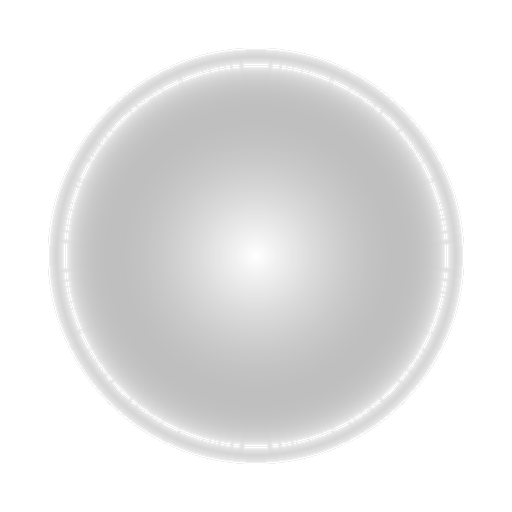

In [14]:
img = Image.open('circle.png') # Image.open('images/amy.webp')
img = outline_simplify(img)
img = gradient_map(img)
display(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-72.0..72.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-723947358930767.0..723947646873126.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-723947358930767.0..723947646873126.0].


(Text(0.5, 1.0, 'Sobel Y'), ([], []), ([], []))

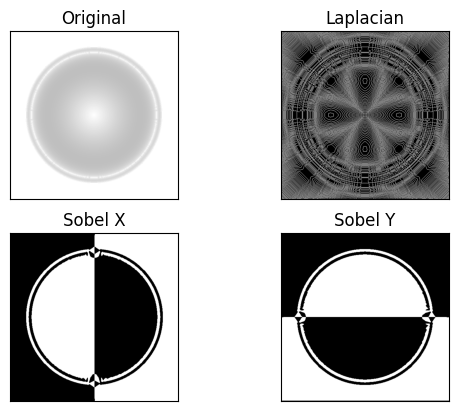

In [15]:
cvimg = cv.cvtColor(np.array(img), cv.COLOR_RGB2BGR)
laplacian = cv.Laplacian(cvimg,cv.CV_64F)
sobelx = cv.Sobel(cvimg,cv.CV_64F,1,0,ksize=25)
sobely = cv.Sobel(cvimg,cv.CV_64F,0,1,ksize=25)

plt.subplot(2,2,1),plt.imshow(img,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])


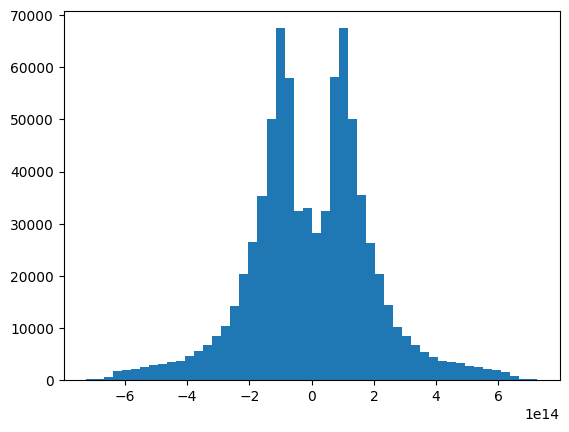

In [22]:
plt.hist(sobelx.flatten(), bins=50)
plt.show()

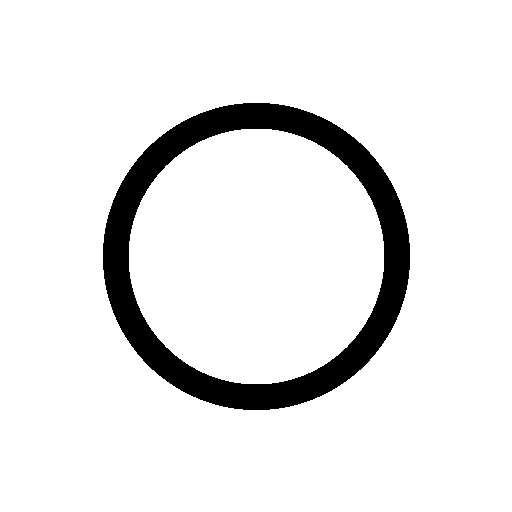

In [4]:
sz = 512
sample_image = Image.new('RGBA', (sz, sz))
pixels = sample_image.load()
for i in range(sample_image.size[0]):
    for j in range(sample_image.size[1]):
        dis = ((sz/2 - i)**2 + (sz/2 - j)**2)**(1/2)
        if dis < 0.25*sz:
            pixels[i,j] = (255, 255, 255, 255)
        elif 0.25*sz <= dis < 0.3*sz:
            pixels[i,j] = (0, 0, 0, 255)
        else:
            pixels[i,j] = (0, 0, 0, 0)
display(sample_image)


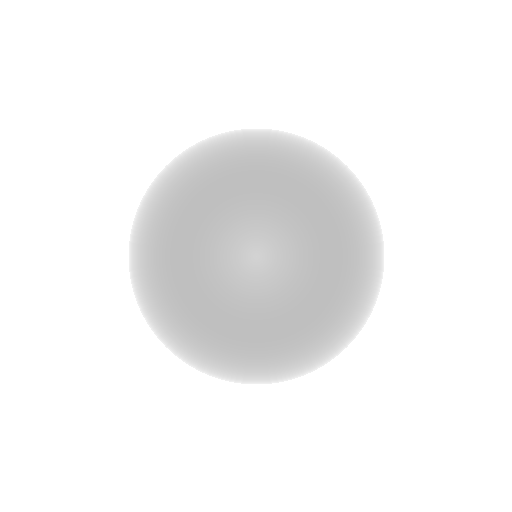

In [5]:
img = sample_image
output_image = gradient_map(img, thresh=3)

display(output_image)

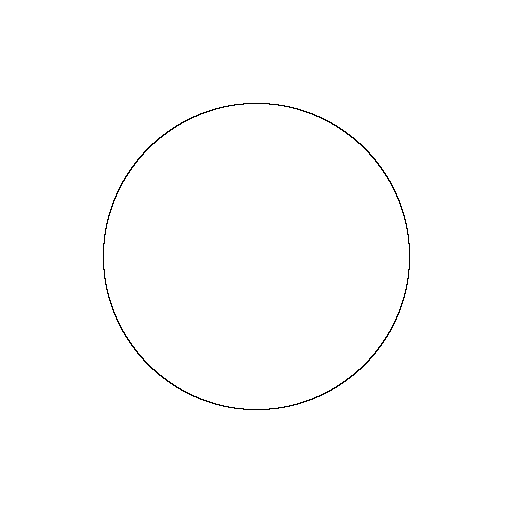

In [6]:
img = sample_image
output_image = outline_simplify(img)
display(output_image)

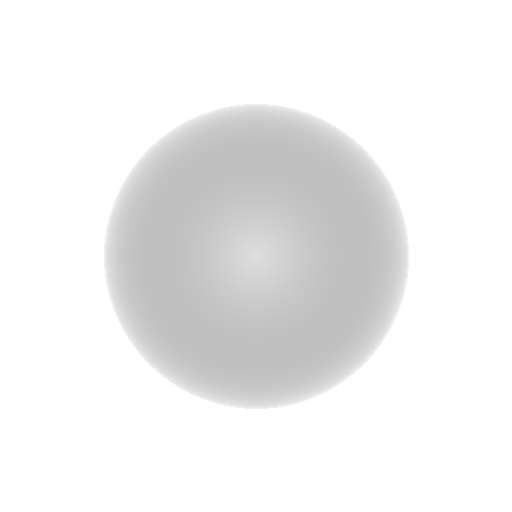

In [7]:
mapped_image = gradient_map(output_image)
display(mapped_image)